# Part 1: Cross validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In this part we follow the first part of the lab of Section 4 of our textbook to learn how to implement cross validation in Python (see [here](https://islp.readthedocs.io/en/latest/labs/Ch05-resample-lab.html) for the original version of the Lab)


## 1a) Validation set approach

**Objective of part 1a)**: Use the validation set approach to evaluate the performance of a model predicting `mpg` in the `Auto` dataset based on predictor `horsepower`.

In [3]:
# Run this cell to load the dataset
Auto =  load_data('Auto')

### Task 1.1: 
Split the dataset into a train and a test part. Your test set should have 196 samples.

In [4]:
train, validation = train_test_split(Auto, test_size=196)

In [5]:
train

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
140,26.0,4,79.0,67,1963,15.5,74,2,volkswagen dasher
155,15.0,8,350.0,145,4440,14.0,75,1,chevrolet bel air
157,14.0,8,351.0,148,4657,13.5,75,1,ford ltd
170,25.0,4,90.0,71,2223,16.5,75,2,volkswagen dasher
165,29.0,4,97.0,75,2171,16.0,75,3,toyota corolla
...,...,...,...,...,...,...,...,...,...
74,14.0,8,318.0,150,4077,14.0,72,1,plymouth satellite custom (sw)
253,25.1,4,140.0,88,2720,15.4,78,1,ford fairmont (man)
45,22.0,4,140.0,72,2408,19.0,71,1,chevrolet vega (sw)
209,16.5,6,168.0,120,3820,16.7,76,2,mercedes-benz 280s


In [6]:
validation

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
150,19.0,6,225.0,95,3264,16.0,75,1,plymouth valiant custom
48,23.0,4,122.0,86,2220,14.0,71,1,mercury capri 2000
297,27.2,4,141.0,71,3190,24.8,79,2,peugeot 504
305,26.8,6,173.0,115,2700,12.9,79,1,oldsmobile omega brougham
321,27.9,4,156.0,105,2800,14.4,80,1,dodge colt
...,...,...,...,...,...,...,...,...,...
249,20.2,8,302.0,139,3570,12.8,78,1,mercury monarch ghia
354,28.1,4,141.0,80,3230,20.4,81,2,peugeot 505s turbo diesel
241,21.5,3,80.0,110,2720,13.5,77,3,mazda rx-4
266,27.2,4,119.0,97,2300,14.7,78,3,datsun 510


### Task 1.2:
Train a simple linear regression model on the training set which predicts `mpg` based on the unique predictor `horsepower`. Make sure to use the training set to train your model.

In [7]:
design = MS(['horsepower']).fit(train)
X_train = design.transform(train)
X_train

,intercept,horsepower
140,1.0,67
155,1.0,145
157,1.0,148
170,1.0,71
165,1.0,75
...,...,...
74,1.0,150
253,1.0,88
45,1.0,72
209,1.0,120


In [8]:
y_train = train.mpg

In [9]:
model = sm.OLS(y_train,X_train)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,40.4628,0.984,41.116,0.0
horsepower,-0.1638,0.009,-18.569,0.0


### Task 1.3: 
Now use the validation set to compute an estimate for the model's MSE (mean squared error).

In [10]:
y_valid_actual = validation.mpg
X_validation = design.transform(validation)
y_valid_predicted = results.predict(X_validation)
MSE = np.mean((y_valid_actual - y_valid_predicted)**2)
MSE

26.436508927275323

### Task 1.4:
Below you find a preimplemented function `evalMSE()`. Explain what this function does (what are the arguments, what is the output)?

In [11]:
def evalMSE(predictors,
           train,
           validation):
    # build design matrix and response vector
    design = MS(predictors).fit(train)
    X_train = design.transform(train)
    y_train = train.mpg 

    # train model
    model = sm.OLS(y_train,X_train)
    results = model.fit()

    # compute MSE on the validation set
    y_valid_actual = validation.mpg
    X_validation = design.transform(validation)
    y_valid_predicted = results.predict(X_validation)
    MSE = np.mean((y_valid_actual - y_valid_predicted)**2)
    return MSE

In [12]:
evalMSE(['horsepower'], train, validation)

26.436508927275323

*Solution*: The function takes a set of predictors, a dataframe of training data and a dataframe of validation data as inputs. Based on these it trains a linear regression model on the training data using the predictors provided as arguments. It then computes the test MSE on the provided validation set. This test MSE is then returned as output.

### Task 1.5:

Use the function `evalMSE()` to estimate the MSE on the validation set for linear regression models including successively higher polynomial terms of `horsepower` ranging from degree 1 to degree 3.

In [13]:
from ISLP.models import poly
MSE = []
for i in range(1,4):
    predictors = [poly('horsepower', i)] # choose powers of horsepower as predictors up to degree i+1
    err = evalMSE(predictors, train, validation)
    MSE.append(err)

In [14]:
MSE

[26.43650892727533, 22.271553558500365, 22.67600764499559]

## 1b) Cross validation

Cross validation is implemented most comfortably in `scikit-learn`. In order to use the `scikit-learn` implementation of cross validation with our `statsmodels` linear model, we use the wrapper `sklearn_sm` provided by the `ISLP` library. From the lab in Chapter 5:

"The class `sklearn_sm()` has as its first argument a model from `statsmodels`. It can take two additional optional arguments: `model_str` which can be used to specify a formula, and `model_args` which should be a dictionary of additional arguments used when fitting the model. For example, to fit a logistic regression model we have to specify a family argument. This is passed as `model_args={'family':sm.families.Binomial()}`."

After specifying our design matrix `X` and the vector `y` we call the `scikit-learn` function `cross_validate` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)).

The result is a dictionary which among others contains the `test_score` which we are interested when we use cross validation to estimate the test error.

### Task 1.6:
Run the following cell to initialize an `sklearn_sm` object with a `statsmodels.OLS` model and a `ModelSpec` object with specified predictor `horsepower`, with dataset `X` with removed `mpg` column und with response vector `y`.

In [15]:
model = sklearn_sm(sm.OLS,
                  MS(['horsepower']))
X = Auto.drop(columns = ['mpg'])
y = Auto['mpg']

The function `cross_validate` is the original `scikit-learn` function which carries out cross validation. We provide the following arguments:
- a model which needs `fit()` and `predict()` methods
- a design matrix `X` and a vector of training labels `y`
- the parameter `cv` specifying the number of folds for cross validation.

See the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more details.

### Task 1.7:
Run a Leave-one-out-cross-validation for a simple linear regression model predicting `mpg` based on `horsepower`. To do so, choose as many folds as your dataset has samples using the parameter `cv`.

In [16]:
cv_results = cross_validate(model,
                           X,
                           y,
                           cv = Auto.shape[0])

In [17]:
cv_err = np.mean(cv_results['test_score'])
cv_err

24.23151351792922

### Task 1.8:

We can repeat this procedure to compare different models. In the following we do this with various polynomial fits.

Compute the LOOCV error for models to predict `mpg` based on polynomial powers of `mpg` for degrees 1 to 5.

In [18]:
cv_error = np.zeros(5) #initialize empty vector for CV errors of 5 models
M = sklearn_sm(sm.OLS)
y = Auto['mpg']

# loop over 5 different polynomial models
for i in range(1,6):
    # choose power of horsepowers as predictors up to degree i+1
    predictors = [poly('horsepower', i)]
    X = MS(predictors).fit_transform(Auto)
    #perform cross validation for polynomial model of degree i+i
    cv_results = cross_validate(M,
                               X,
                               y,
                               cv = Auto.shape[0])
    # save cross validation error into result vector
    cv_error[i-1] = np.mean(cv_results['test_score'])
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443031, 19.03321385])

### Task 1.9:

Instead of using $K = n$ folds such as above (resulting in Leave-One-Out-Cross-Validation (LOOCV)) we can also specify a smaller integer $K$ of folds. There are two possibilities for this:
- set `cv = K`,
- specify a cross validation generator such as `KFold` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html))

It is recommended to use the second approach, which is generally preferred as we do better control the kind of split when using `KFold`.

Compute the cross validation error for models to predict `mpg` based on polynomial powers of `mpg` for degrees 1 to 5. Use 10 folds.

In [19]:
cv_error = np.zeros(5)

cross_val = KFold(n_splits = 10,
                 shuffle = True,
                 random_state = 42)

M = sklearn_sm(sm.OLS)
y = Auto['mpg']

# loop over 5 different polynomial models
for i in range(5):
    # choose power of horsepowers as predictors up to degree i+1
    predictors = [poly('horsepower', i+1)]
    X = MS(predictors).fit_transform(Auto)
    #perform cross validation for polynomial model of degree i+i
    cv_results = cross_validate(M,
                               X,
                               y,
                               cv = cross_val)
    # save cross validation error into result vector
    cv_error[i] = np.mean(cv_results['test_score'])
cv_error

array([24.1998082 , 19.22863661, 19.26626535, 19.35109227, 19.02323325])

# Part 2: Case study cross validation (no solutions beyond this point as we did not get further in lecture)

(see Exercise 5.4.5)

In this case study we use the credit card dataset to predict the probability of default. We will build a logistic regression model and estimate its test error using the validation set approach and the cross-validation approach.

In [20]:
# run this cell to load the data
Default = load_data('Default')
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


Background information on the dataset can be found [in the documentation](https://islp.readthedocs.io/en/latest/datasets/Default.html).

## Task 2.1
Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [21]:
predictors = Default.columns.drop(['default','student'])
design = MS(predictors).fit(Default)
X = design.transform(Default)
y = Default.default.map(
    {'No': 0,
    'Yes': 1}
)

model = sm.Logit(y,X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 15 May 2025   Pseudo R-squ.:                  0.4594
Time:                        12:31:34   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

## Task 2.2
Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

ii. Fit a multiple logistic regression model using only the training observations.

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [22]:
# i. splitting into validation and test set
train, val = train_test_split(
    Default,
    test_size=0.3,
    random_state = 42
)

In [23]:
# ii. fit logistic regression model using only training observations
predictors = train.columns.drop(['default','student'])
design2 = MS(predictors).fit(train)
X2 = design2.transform(train)
y2 = train.default.map(
    {'No': 0,
    'Yes': 1}
)

model2 = sm.Logit(y2,X2)
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.078256
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Thu, 15 May 2025   Pseudo R-squ.:                  0.4743
Time:                        12:31:34   Log-Likelihood:                -547.79
converged:                       True   LL-Null:                       -1042.0
Covariance Type:            nonrobust   LLR p-value:                2.273e-215
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.6019      0.522    -22.236      0.000     -12.624     -10.579
balance        0.0057      0.000     20.976      0.000       0.005       0.006
income      1.872e-05   5.92e-06      3.163      0.002    7.12e-06    3.03e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [24]:
# iii. Prediction for validation set
X_val = design2.transform(val)
predicted_probs = results2.predict(X_val)
predicted_labels = np.where(predicted_probs > 0.5, 'Yes', 'No')

In [25]:
# iv. validation set error
true_labels = val.default
val_err = 1 - np.mean(predicted_labels == true_labels)
val_err

0.026666666666666616

In [26]:
from ISLP import confusion_table
confusion_table(predicted_labels, true_labels)

Truth,No,Yes
Predicted,,
No,2896,70
Yes,10,24


## Task 2.3
Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [27]:
# your code here
val_errors = np.zeros(3)
for i in range(3):
    train, val = train_test_split(
        Default,
        test_size=0.3
    )
    predictors = train.columns.drop(['default','student'])
    design3 = MS(predictors).fit(train)
    X3 = design3.transform(train)
    y3 = train.default.map(
        {'No': 0,
        'Yes': 1}
    )

    model3 = sm.Logit(y3,X3)
    results3 = model3.fit()
    X_val = design3.transform(val)
    predicted_probs = results2.predict(X_val)
    predicted_labels = np.where(predicted_probs > 0.5, 'Yes', 'No')
    true_labels = val.default
    val_err = 1 - np.mean(predicted_labels == true_labels)
    val_errors[i] = val_err
val_errors

Optimization terminated successfully.
         Current function value: 0.075228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083036
         Iterations 10


array([0.029     , 0.02433333, 0.02166667])

**Comment**: The fraction of observations which are misclassified varies slightly due to the fact that we use different validation sets (no random seed set!) in each of the three iterations.

## Task 2.4
Now predict the test error of the model using 10-fold cross-validation. To do so, follow the steps we developed in Part 1b) of this notebook.

**Note**: To carry out this task, we need to define our own custom score using [`sklearn.make_scorer()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and pass this to the function [`sklearn.cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) by specifying it as an argument to the `scoring` parameter.

Our custom scoring function needs to have the signature `score_func(y, y_pred, **kwargs)` with `y` being the true labels and `y_pred` the predicted labels as output by `sm.Logit()` when applying the `predict()` method. Since `statsmodels` outputs probabilities rather than actual labels, we first transform these probabilities  into labels. This is what our scoring function `accuracy_score_sm()` does.

In [28]:
# Step 1: Define custom scorer which computes accuracy based on probabilities as
# output by statsmodels
from sklearn.metrics import make_scorer
def accuracy_score_sm(y_true, y_pred_prob):
    # computes the accuracy for the output of a binary classification model

    # inputs:
    #    y_true: ground truth labels, encoded as 0,1
    #    y_pred_prob: probabilities for label 1 as predicted by the model

    # output:
    #    percentage of models 
    y_pred = np.round(y_pred_prob)
    return np.mean(y_true == y_pred)
accuracy_sm = make_scorer(accuracy_score_sm)

# Step 2: Initialize splitter for cross validation and model
cross_val = KFold(n_splits = 10,
                 shuffle = True,
                 random_state = 42)

M = sklearn_sm(sm.Logit)

# Step 3: Define response variable and design matrix for cross validation
y = Default['default'].map({
    'No' : 0,
    'Yes' : 1
})
predictors = ['income', 'balance']
X = MS(predictors).fit_transform(Default)

# Step 4: Run cross validation
cv_results = cross_validate(M,
                            X,
                            y,
                            scoring = accuracy_sm,
                            cv = cross_val)
print('Mean accuracy: ', np.mean(cv_results['test_score']))

Optimization terminated successfully.
         Current function value: 0.077489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080798
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081253
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079803
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077491
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

## Task 2.5
Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using 10-fold cross-validation. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [29]:
# Step 1: Initialize splitter for cross validation and model
# reuse the cross validator from Task 1.4

# Step 2: Define response variable and design matrix for cross validation
# reuse y from Task 1.4
predictors=['income', 'balance', 'student']
X = MS(predictors).fit_transform(
    Default.astype({'student': 'category'}))

# Step 3: Run cross validation
cv_results = cross_validate(M,
                           X,
                           y,
                           scoring = accuracy_sm,
                           cv = cross_val)

print('Mean accuracy: ', np.mean(cv_results['test_score']))

Optimization terminated successfully.
         Current function value: 0.077174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077718
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080384
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076316
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079514
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078307
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077439
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.

**Interpretation**: There is no evidence that adding student as additional predictor helps to improve the model accuracy. Hence, we would decide based on this analysis to leave student out.

# Part 3: Implementation of bootstrap

## Bootstrapping for estimating the accuracy of a statistic
### Introducing the dataset
We closely follow an example presented in [Computational and Inferential Thinking](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html).

In [30]:
url = 'https://drive.google.com/uc?id='
file_id = "15xUDQPqkzKJBoxrafC9iNz4EgFlwbmM_"
births = pd.read_csv(url + file_id)
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


#### Task 3.1

Create a new column `Birth Weight (g)` which contains the birth weight in g. Use the fact 1oz = 28.3495g for your computations.

In [31]:
births['Birth Weight (g)'] = births['Birth Weight'] * 28.3495
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Birth Weight (g)
0,120,284,27,62,100,False,3401.9400
1,113,282,33,64,135,False,3203.4935
2,128,279,28,64,115,True,3628.7360
3,108,282,23,67,125,True,3061.7460
4,136,286,25,62,93,False,3855.5320
...,...,...,...,...,...,...,...
1169,113,275,27,60,100,False,3203.4935
1170,128,265,24,67,120,False,3628.7360
1171,130,291,30,65,150,True,3685.4350
1172,125,281,21,65,110,False,3543.6875


Birth weight is an important factor in the health of a newborn infant. Smaller babies tend to need more medical care in their first days than larger newborns. It is therefore helpful to have an estimate of birth weight before the baby is born. One way to do this is to examine the relationship between birth weight and the number of gestational days.

A simple measure of this relationship is the ratio of birth weight to the number of gestational days. The table ratios contains the first two columns of baby, as well as a column of the ratios. The first entry in that column was calculated as follows:
$$ \frac{3401.94 \text{oz}}{284 \text{ days}} \approx 11.98 \text{g} \text{ per day}.$$

In [32]:
ratios = pd.DataFrame({
    'Birth Weight' : births['Birth Weight (g)'],
    'Ratio BW:GD' : births['Birth Weight (g)'] / births['Gestational Days']
})
ratios

,Birth Weight,Ratio BW:GD
0,3401.9400,11.978662
1,3203.4935,11.359906
2,3628.7360,13.006222
3,3061.7460,10.857255
4,3855.5320,13.480881
...,...,...
1169,3203.4935,11.649067
1170,3628.7360,13.693343
1171,3685.4350,12.664725
1172,3543.6875,12.610988


#### Task 3.2

Plot a histogram of the ratios.

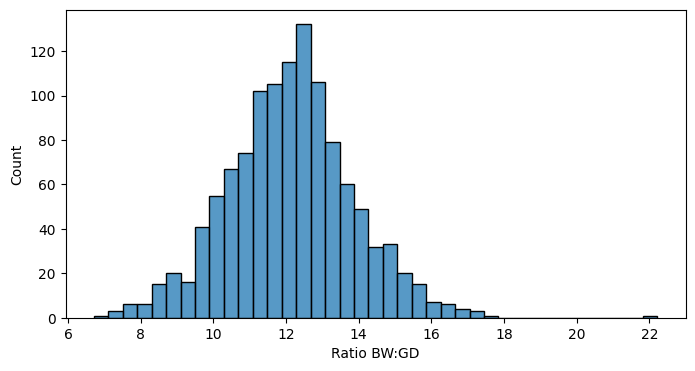

In [33]:
fig,ax = plt.subplots(figsize = (8,4))
sns.histplot(ratios, x = "Ratio BW:GD");

#### Task 3.3

Compute the median ratio and the maximum ratio in the sample.

In [34]:
print('Median of ratios = ',ratios['Ratio BW:GD'].median())
print('Maximum of ratios = ',ratios['Ratio BW:GD'].max())

Median of ratios =  12.164147163120568
Maximum of ratios =  22.21987837837838


### Estimating the variability of the population median
We now want to estimate the population median. For this we are going to use the bootstrapping method.
We start by reviewing the idea in a graphical manner:
![bootstrap.png](bootstrap.png)

#### Task 3.4

Define a function `one_bootstrap_median` which will bootstrap the sample and return the median ratio in the bootstrapped sample.

- To bootstrap the sample use the Pandas.DataFrame method [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html). *Important*: Make sure to draw a sample of the same length as our original sample and make sure to sample with replacement.

In [35]:
def one_bootstrap_median():
    bootstrap_sample = ratios.sample(frac = 1,replace = True)
    return bootstrap_sample['Ratio BW:GD'].median()

one_bootstrap_median()

12.179027075812273

#### Task 3.5

Initialize a Numpy vector `bootstrap_medians` with zeros of length 5000 (use the Numpy method [`zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy.zeros). Then fill this vector with 5000 bootstrapped medians.

In [36]:
n = 5000
bootstrap_medians = np.zeros(n)
for i in range(n):
    bootstrap_medians[i] = one_bootstrap_median()

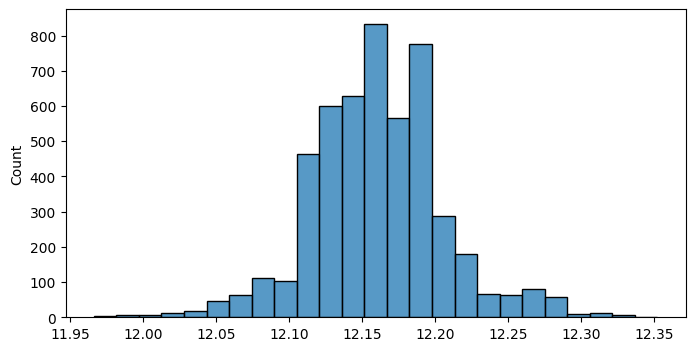

In [37]:
fig,ax  = plt.subplots(figsize =(8,4))
sns.histplot(x = bootstrap_medians, bins=25);

## Bootstrapping for estimating the accuracy of a Linear Regression Model
Now, we discuss how to use bootstrapping in order to assess the variability of the coefficient estimates and predictions from a statistical learning method. As an example, we look at a simple linear regression model based on the `Auto` dataset which predicts the `mpg` variable based on `horsepower`.

With the bootstrap method we are going to estimate the distribution of the coefficient for `mpg` in this model and we compare the standard error of this coefficient as estimated by `statsmodels` with our bootstrap estimate.

In [38]:
Auto = load_data('Auto')

#### Task 3.6 

Define a function `one_bootstrap_model_coefficient` which creates a single bootstrap sample from the Auto dataframe, computes a regression model based on the single predictor `horsepower` and returns the model coefficient for `horsepower`.

In [39]:
def one_bootstrap_model_coefficient():
    bootstrap_sample = Auto.sample(frac = 1, replace = True)
    predictors = ['horsepower']
    X = MS(predictors).fit_transform(bootstrap_sample)
    y = bootstrap_sample.mpg
    model = sm.OLS(y,X).fit()
    return model.params['horsepower']

one_bootstrap_model_coefficient()

-0.15354302641161216

#### Task 3.7

Initialize a Numpy vector `bootstrap_model_coefficients` with zeros of length 5000 (use the Numpy method [`zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy.zeros). Then fill this vector with 5000 bootstrapped model coefficients.

In [40]:
n = 5000
bootstrap_model_coefficients = np.zeros(n)
for i in range(n):
    bootstrap_model_coefficients[i] = one_bootstrap_model_coefficient()

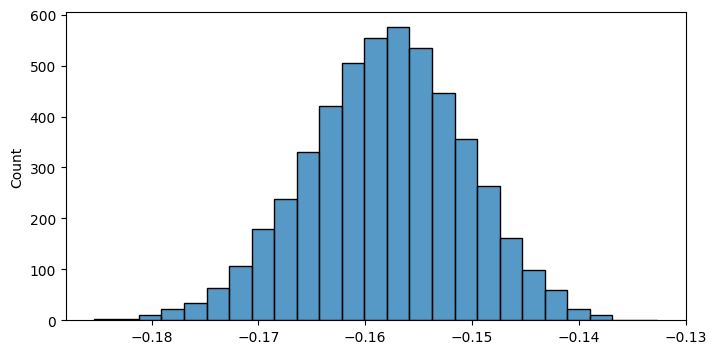

In [41]:
fig,ax  = plt.subplots(figsize =(8,4))
sns.histplot(x = bootstrap_model_coefficients, bins=25);

#### Task 3.8 

Estimate the standard error of the model coefficient for `horsepower` and assign it to the variable `standard_error_bootstrap`. Compare to the `sm.OLS()` estimate which should be assigned to the variable `standard_error_bootstrap`.

In [42]:
standard_error_bootstrap = np.std(bootstrap_model_coefficients)

# compute statsmodels OLS model using the full dataset
predictors = ['horsepower']
X = MS(predictors).fit_transform(Auto)
y = Auto.mpg
model = sm.OLS(y,X).fit()
standard_error_statsmodels = model.bse['horsepower']

print('Bootstrapped standard error for model coefficient:', "{:10.4f}".format(standard_error_bootstrap))
print('Statsmodels OLS standard error estimate for model coefficient:', "{:10.4f}".format(standard_error_statsmodels))

Bootstrapped standard error for model coefficient:     0.0074
Statsmodels OLS standard error estimate for model coefficient:     0.0064


# Part 4: Case study bootstrap

We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the `Default` data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: 
1. using the bootstrap, and 
2. using the standard formula for computing the standard errors in the sm.GLM() function.

In [43]:
# run this cell to load the data
Default = load_data('Default')
Default

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


## Task 4.1
Using the `summarize()` and `sm.GLM()` functions, determine the estimated standard errors for the coefficients associated with `income` and `balance` in a multiple logistic regression model that uses both predictors.

In [44]:
predictors = Default.columns.drop(['student', 'default'])
design = MS(predictors).fit(Default)
X = design.transform(Default)

y = Default.default.map({
    'No' : 0,
    'Yes' : 1
})

model = sm.Logit(y,X)
results = model.fit()
summarize(results)

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
balance,0.005600,0.000000,24.835,0.0
income,0.000021,0.000005,4.174,0.0


## Task 4.2
Following the bootstrap example in Part 2 above, estimate the standard errors of the logistic regression coefficients for income and balance with the bootstrap.

In [45]:
# Step 1: Define function to compute one bootstrap sample of the model coefficients
def one_bootstrap_model_coefficients():
    resample = Default.sample(frac = 1, 
                           replace = True)
    X_bs = design.transform(resample)
    y_bs = y[X_bs.index]
    results_bs = sm.Logit(y_bs,X_bs).fit(disp=0) # disp=0 option mutes output of fit()
    return results_bs.params['balance'], results_bs.params['income']
one_bootstrap_model_coefficients()

(0.005737329659827029, 1.6877069038868157e-05)

In [46]:
# Step 2: 
n_bs_samples = 5000
balance_coefficients = np.zeros(n_bs_samples)
income_coefficients = np.zeros(n_bs_samples)
for i in range(n_bs_samples):
    balance_coefficients[i], income_coefficients[i] = one_bootstrap_model_coefficients()

In [47]:
# Step 3a: comparison of bootstrap standard errors and standard errors as per statsmodels.Logit() - balance
print('Bootstrap estimation of standard error for balance parameter:   ', 
      '{:6e}'.format(np.std(balance_coefficients))
)
print('Statsmodels estimation of standard error for balance parameter: ', 
      '{:6e}'.format(summarize(results).loc['balance','std err'])
)

Bootstrap estimation of standard error for balance parameter:    2.255423e-04
Statsmodels estimation of standard error for balance parameter:  0.000000e+00


In [48]:
# Step 3b: comparison of bootstrap standard errors and standard errors as per statsmodels.Logit() - income
print('Bootstrap estimation of standard error for income parameter:   ', 
      '{:6e}'.format(np.std(income_coefficients))
)
print('Statsmodels estimation of standard error for income parameter: ', 
      '{:6e}'.format(summarize(results).loc['income','std err'])
)

Bootstrap estimation of standard error for income parameter:    4.847566e-06
Statsmodels estimation of standard error for income parameter:  4.990000e-06


## Task 4.3

Comment on the estimated standard errors obtained using the `sm.Logit()`/`sm.GLM()` function and using the bootstrap.

**Comment**:
- For `balance` the standard error estimated by `statsmodels.Logit()` is 0.0, which is quite different from the bootstrap standard error of 2.26e-04.
- For `income` the bootstrap estimate of the standard error is similar to the one estimated by `statsmodels`.